
# Лабораторная работа №4  
## Кластеризация данных

**Цель работы:** изучить и сравнить методы кластеризации на примере поведенческих данных о клиентах торгового центра, а также получить осмысленные сегменты покупателей и оценить качество кластеризации с использованием внутренних метрик.



## 1. Описание датасета и постановка задачи

В работе используется датасет **Mall Customers** с платформы Kaggle.  
Наблюдение соответствует одному покупателю и включает следующие признаки:

* `CustomerID` — идентификатор клиента;
* `Gender` — пол;
* `Age` — возраст;
* `Annual Income (k$)` — годовой доход в тысячах долларов;
* `Spending Score (1-100)` — оценка расходов, выставленная маркетинговым отделом (чем выше, тем больше клиент тратит).

В рамках лабораторной работы требуется:

* провести дескриптивный анализ данных (размерность, типы признаков, пропуски, распределения);
* оценить информативность признаков и осмысленность постановки задачи кластеризации;
* выполнить масштабирование числовых признаков и обосновать выбор метода;
* реализовать кластеризацию двумя различными алгоритмами;
* подобрать оптимальное количество кластеров (для методов, требующих параметр *k*);
* рассчитать метрики качества кластеризации и интерпретировать результаты;
* исследовать влияние параметров одного из методов (количество кластеров *k* для KMeans);
* визуализировать кластеры и содержательно интерпретировать полученные группы клиентов.


## 2. Импорт библиотек и загрузка данных

In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

plt.style.use("seaborn-v0_8")

df = pd.read_csv("Mall_Customers.csv")

df.head()


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### 2.1. Дескриптивный анализ: размерность, типы признаков, пропуски

In [2]:

print("Размерность датасета (строки, столбцы):", df.shape)
print("\nТипы признаков:")
print(df.dtypes)

print("\nЧисло пропусков по столбцам:")
print(df.isna().sum())


Размерность датасета (строки, столбцы): (200, 5)

Типы признаков:
CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

Число пропусков по столбцам:
CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


Датасет содержит 200 объектов и 5 признаков, включая идентификатор, категориальный признак Genre и три числовых признака: Age, Annual Income (k$), Spending Score (1–100).
Пропуски отсутствуют, что позволяет использовать весь объём данных без дополнительной очистки.

Гистограммы показывают, что Age и Income распределены умеренно несимметрично, а Spending Score имеет практически равномерное распределение с выделением пиков в диапазонах 30–40 и 60–70.
Матрица корреляций демонстрирует низкую взаимосвязь между признаками: наиболее заметна слабая отрицательная связь между Age и Spending Score (r ≈ –0.33). Это означает, что признаки несут разную информацию и пригодны для сегментации.

### 2.2. Распределение числовых признаков и анализ выбросов

In [3]:

numeric_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
df[numeric_cols].describe()


,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


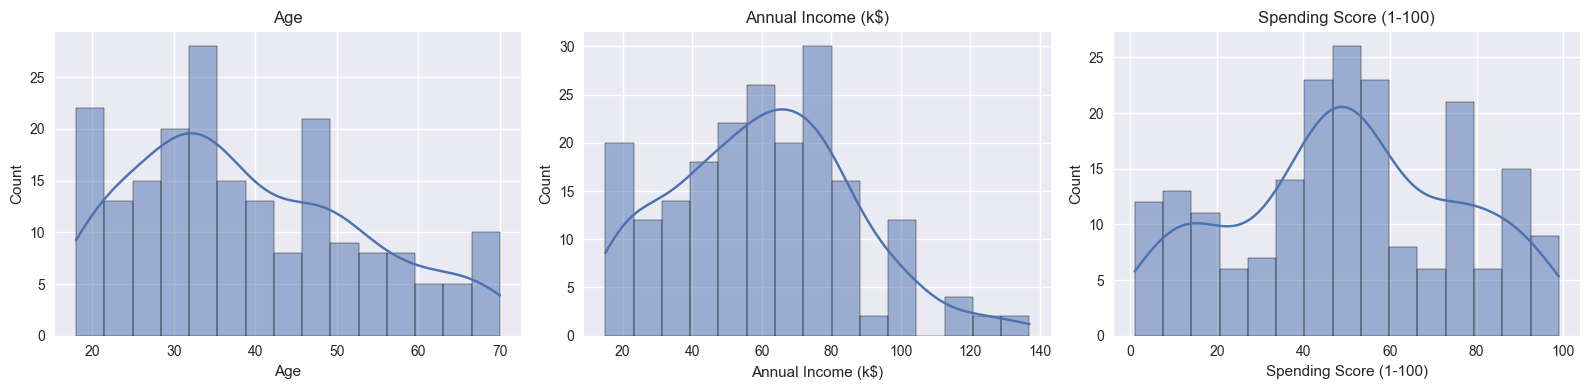

In [4]:

fig, axes = plt.subplots(1, len(numeric_cols), figsize=(16, 4))
for ax, col in zip(axes, numeric_cols):
    sns.histplot(df[col], bins=15, kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()


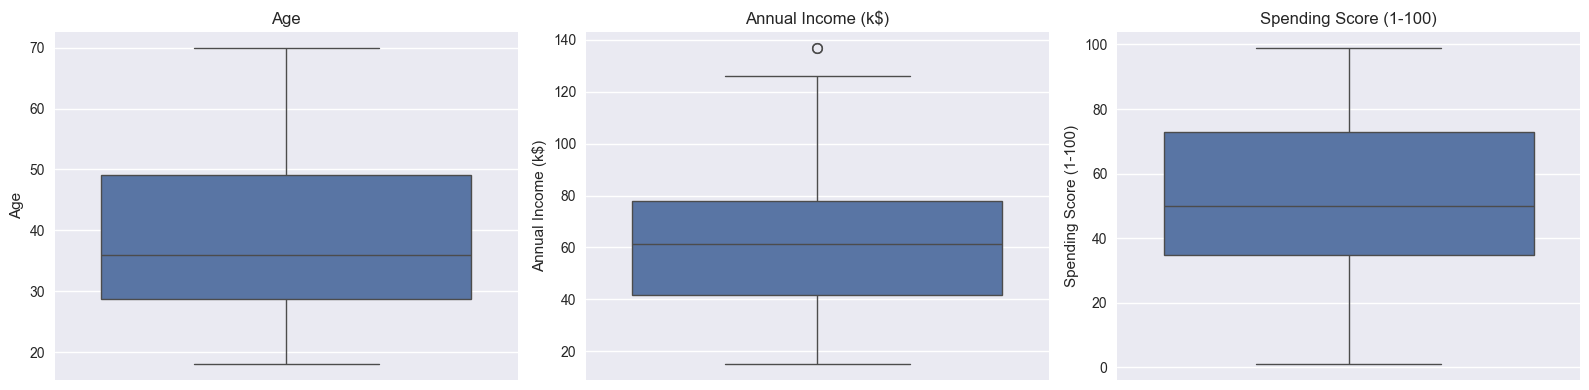

In [5]:

fig, axes = plt.subplots(1, len(numeric_cols), figsize=(16, 4))
for ax, col in zip(axes, numeric_cols):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()



Гистограммы показывают, что:

* возраст распределён несимметрично, с концентрацией клиентов в диапазоне 20–40 лет;
* доход имеет ближе к равномерному распределению на отрезке примерно от 15 до 140 тысяч долларов;
* показатель `Spending Score` распределён близко к равномерному, что отражает наличие клиентов с разными моделями поведения — от экономных до активно тратящих.

Boxplot-графики не выявляют сильных выбросов: значения находятся в разумных пределах, что позволяет применять алгоритмы кластеризации, основанные на евклидовом расстоянии, без дополнительной очистки.


### 2.3. Оценка информативности признаков и корреляции

In [6]:

corr = df[numeric_cols].corr()
corr


,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


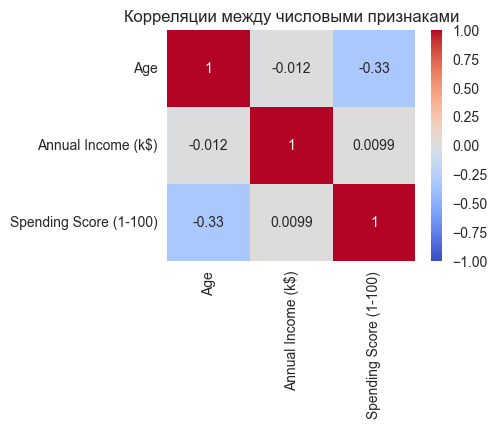

In [7]:

plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляции между числовыми признаками")
plt.show()


Полученные значения показывают, что между возрастом и годовым доходом корреляционная связь практически отсутствует: коэффициент составляет около −0,01, что указывает на статистически незначимую и фактически нулевую линейную зависимость. Это означает, что в рамках данного набора данных возраст клиента не определяет уровень его дохода и наоборот, поэтому эти признаки можно рассматривать как независимые с точки зрения линейных отношений.

Между годовым доходом и показателем Spending Score также наблюдается практически нулевая корреляция (около 0,01). Такой результат указывает на то, что уровень дохода сам по себе не объясняет интенсивность потребительских трат, зафиксированную в виде поведенческого индекса. Это важный вывод для дальнейшей кластеризации, поскольку он показывает, что клиенты с одинаковым доходом могут демонстрировать принципиально разное покупательское поведение.

Наиболее выраженная зависимость наблюдается между возрастом и Spending Score, где коэффициент корреляции составляет примерно −0,33. Данная величина указывает на умеренную отрицательную линейную связь: с увеличением возраста склонность к активным тратам в среднем снижается. Однако сила этой зависимости недостаточна для того, чтобы говорить о жёсткой функциональной связи, что подтверждает сохранение высокой вариативности поведения внутри возрастных групп.

## 3. Предобработка данных

### 3.1. Кодирование категориального признака и выбор признаков для кластеризации

In [8]:

df["Gender_bin"] = (df["Genre"] == "Male").astype(int)

features = numeric_cols
X = df[features].copy()

X.head()


,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40



Кластеризацию будем выполнять в пространстве числовых признаков `Age`, `Annual Income (k$)` и `Spending Score (1-100)`.  
Признак пола можно использовать для последующей интерпретации кластеров, но в сам алгоритм кластеризации он не включается, чтобы не смешивать поведенческие и социально-демографические характеристики.


### 3.2. Масштабирование признаков

In [9]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]


array([[-1.42456879, -1.73899919, -0.43480148],
       [-1.28103541, -1.73899919,  1.19570407],
       [-1.3528021 , -1.70082976, -1.71591298],
       [-1.13750203, -1.70082976,  1.04041783],
       [-0.56336851, -1.66266033, -0.39597992]])


Для масштабирования выбран метод **StandardScaler** (standartization), приводящий каждый признак к нулевому среднему и единичному стандартному отклонению.  

Обоснование выбора:

* Алгоритмы KMeans и иерархической кластеризации используют евклидово расстояние, чувствительное к масштабу признаков.
* Входные признаки имеют разные единицы измерения (годы, тысячи долларов, безразмерный скор), поэтому без стандартизации доход доминировал бы над другими переменными.
* Стандартизация сохраняет относительные различия между объектами и позволяет корректно сравнивать расстояния в многомерном пространстве.


### 3.3. Матрица диаграмм рассеивания

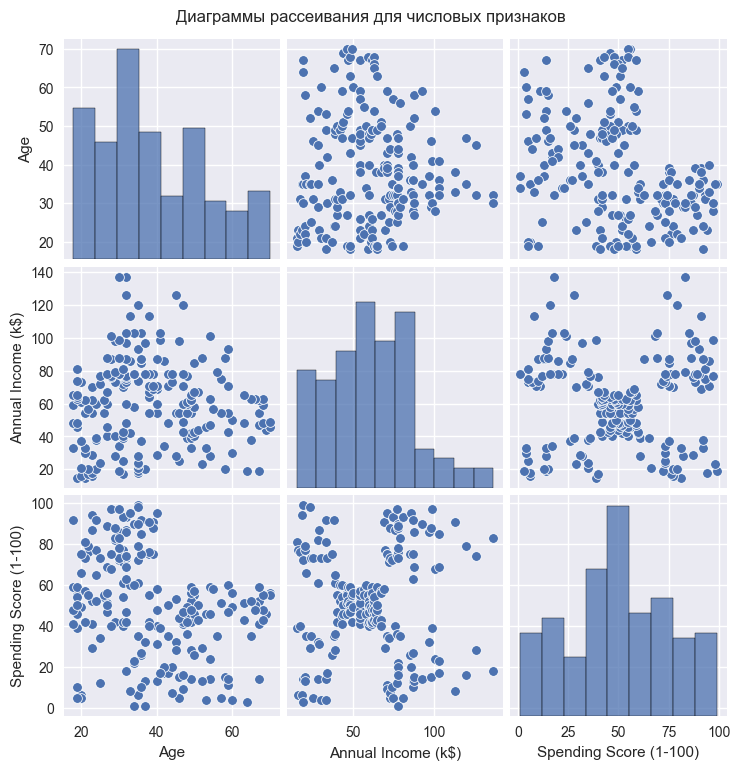

In [10]:

sns.pairplot(df[features], diag_kind="hist")
plt.suptitle("Диаграммы рассеивания для числовых признаков", y=1.02)
plt.show()


Гистограмма возраста показывает неравномерное распределение клиентов с концентрацией наблюдений в интервале примерно от 20 до 50 лет, при этом крайние возрастные значения представлены заметно реже. Это указывает на то, что выборка ориентирована преимущественно на экономически активное население, что важно учитывать при интерпретации результатов кластеризации, поскольку поведение пожилых и очень молодых клиентов представлено ограниченно.

Распределение годового дохода характеризуется выраженной асимметрией и наличием нескольких локальных максимумов, что свидетельствует о присутствии различных доходных групп внутри выборки. Диапазон доходов достаточно широк, что создаёт предпосылки для формирования устойчивых кластеров по уровню финансовых возможностей клиентов.

Гистограмма показателя Spending Score демонстрирует распределение, близкое к равномерному, без ярко выраженного единственного пика. Это указывает на высокую вариативность потребительского поведения и отсутствие доминирующего типа клиентов по уровню трат, что является благоприятным фактором для сегментации.

Попарные диаграммы рассеяния подтверждают выводы корреляционного анализа: между возрастом и годовым доходом отсутствует чёткая линейная зависимость, точки распределены диффузно по всей области. Это означает, что клиенты разных возрастов могут иметь сопоставимые уровни дохода, и возраст не является определяющим фактором финансового положения в данной выборке.

На плоскости «возраст – Spending Score» прослеживается тенденция к снижению потребительской активности с увеличением возраста, однако связь носит умеренный и нелинейный характер. Видно, что среди молодых клиентов присутствуют как группы с высокой, так и с низкой склонностью к тратам, что указывает на внутреннюю неоднородность этой возрастной категории.

На диаграмме «годовой доход – Spending Score» наблюдается наиболее интересная структура: точки формируют несколько сгущений, соответствующих группам клиентов с разным сочетанием дохода и потребительского поведения. Присутствуют клиенты с высоким доходом и низкими тратами, а также клиенты со средним доходом и высокой активностью потребления. Данная неоднородность визуально подтверждает целесообразность применения методов кластеризации, поскольку в пространстве признаков явно просматриваются потенциальные сегменты клиентов, которые не могут быть описаны простой линейной моделью.

## 4. Кластеризация методом KMeans

### 4.1. Подбор оптимального числа кластеров (метод локтя и анализ силуэта)

In [11]:

inertias = []
silhouettes = []
k_values = range(2, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

inertias, silhouettes


([389.38618895643714,
  295.2122461555488,
  205.2251474767592,
  168.24758017556837,
  133.86842085478855,
  117.01155455889813,
  103.87329152383712,
  93.09289110041726,
  82.385153645266],
 [0.3354719289400457,
  0.357793388710272,
  0.4039582785148566,
  0.41664341513732767,
  0.42841677628925934,
  0.417231894954916,
  0.4082067042807375,
  0.41769250624076476,
  0.40655411010117004])

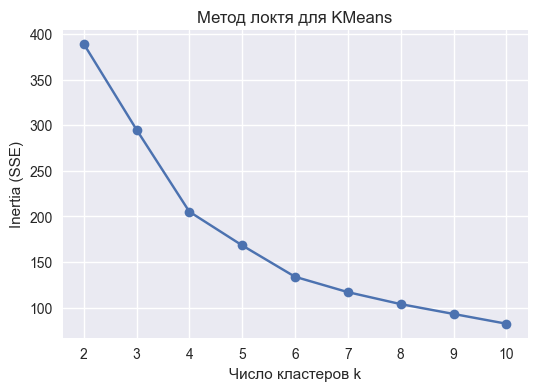

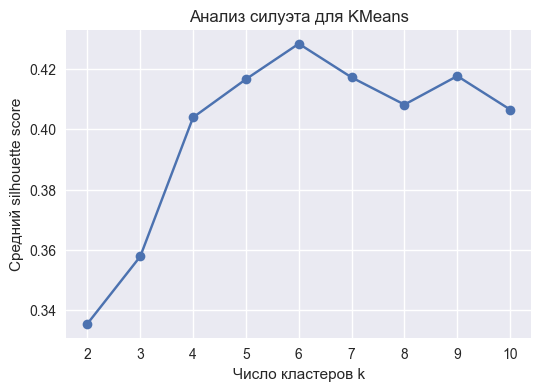

In [12]:

fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(k_values, inertias, marker="o")
ax1.set_xlabel("Число кластеров k")
ax1.set_ylabel("Inertia (SSE)")
ax1.set_title("Метод локтя для KMeans")
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 4))
ax2.plot(k_values, silhouettes, marker="o")
ax2.set_xlabel("Число кластеров k")
ax2.set_ylabel("Средний silhouette score")
ax2.set_title("Анализ силуэта для KMeans")
plt.show()


Метод локтя показывает, что резкое снижение SSE наблюдается до k≈5, после чего темп падения убывает.
Анализ силуэта приводит к максимуму при k = 6 (silhouette ≈ 0.428), но значения для k = 5 (0.4166) близки и более интерпретируемы.

Учитывая компромисс между устойчивостью, качеством и содержательной трактуемостью, выбрано k = 5.

### 4.2. Обучение модели KMeans и визуализация кластеров

In [13]:

k_opt = 5
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

df["Cluster_KMeans"] = kmeans_labels

sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
db_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)

sil_kmeans, db_kmeans


(0.41664341513732767, 0.874551051002418)

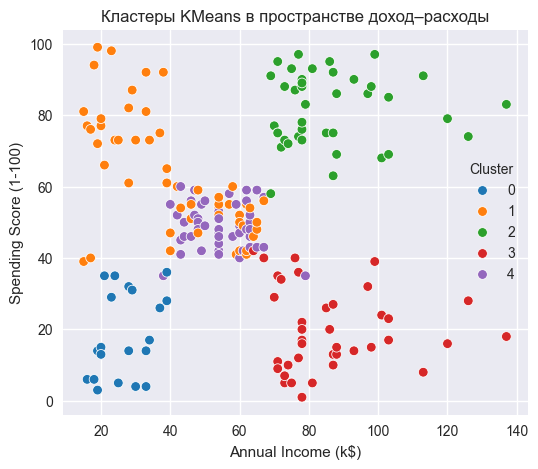

In [14]:

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df, x="Annual Income (k$)", y="Spending Score (1-100)",
    hue="Cluster_KMeans", palette="tab10"
)
plt.title("Кластеры KMeans в пространстве доход–расходы")
plt.legend(title="Cluster")
plt.show()


Полученные метрики качества:
- Silhouette Score = 0.4166
- Davies–Bouldin = 0.8746

Результаты считаются хорошими для поведенческих данных, где кластеры редко имеют чёткие границы.

Интерпретация сегментов:
- Кластер 0 — низкий доход, низкая склонность к тратам (экономные клиенты).
- Кластер 1 — низкий доход, но высокая активность покупок (молодая импульсивная группа).
- Кластер 2 — высокий доход, высокая активность покупок (премиальный сегмент).
- Кластер 3 — высокий доход, но низкая покупательная активность (рациональные клиенты).
- Кластер 4 — средний доход / средняя активность (стабильный основной сегмент).

Хорошо видно, что кластеры в этом пространстве формируются достаточно чётко и занимают различные области плоскости, что указывает на адекватный выбор числа кластеров. Нижняя левая область представлена кластером с низким уровнем дохода и низким Spending Score, что соответствует клиентам с ограниченными финансовыми возможностями и слабой потребительской активностью. Эти наблюдения компактно сгруппированы, что говорит о высокой однородности данной группы.

В верхней левой части графика выделяется кластер клиентов с низким доходом, но высоким уровнем трат. Это указывает на группу, склонную к активному потреблению несмотря на ограниченный доход, что может отражать импульсивное или ориентированное на потребление поведение. Чёткое отделение этого кластера от группы с низкими тратами подтверждает, что доход сам по себе не определяет покупательскую активность.

В центральной части графика наблюдается кластер со средними значениями дохода и Spending Score. Данная группа характеризуется наибольшей плотностью точек и перекрывает промежуточную зону между крайними сегментами. Такое расположение указывает на клиентов со сбалансированным потребительским поведением, которые не демонстрируют ярко выраженной склонности ни к экономии, ни к чрезмерным тратам.

В правой верхней области располагается кластер клиентов с высоким доходом и высоким Spending Score. Эти клиенты обладают значительными финансовыми возможностями и активно расходуют средства, что делает данный сегмент потенциально наиболее ценным с точки зрения бизнеса. Относительная компактность кластера свидетельствует о сходстве поведения внутри группы.

Наконец, в правой нижней части выделяется кластер с высоким доходом и низкой потребительской активностью. Несмотря на высокий уровень дохода, клиенты данного сегмента демонстрируют склонность к сдержанному потреблению. Наличие такого кластера подчёркивает, что потребительское поведение определяется не только доходом, но и индивидуальными предпочтениями и стилем жизни.

### 4.3. Анализ центров кластеров KMeans

In [15]:

# Преобразуем центры обратно в исходный масштаб признаков
centers_scaled = kmeans.cluster_centers_
centers = pd.DataFrame(
    scaler.inverse_transform(centers_scaled),
    columns=features
)
centers["Cluster"] = range(k_opt)
centers


,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,46.250000,26.750000,18.350000,0
1,25.185185,41.092593,62.240741,1
2,32.875000,86.100000,81.525000,2
3,39.871795,86.102564,19.358974,3
4,55.638298,54.382979,48.851064,4



Центры кластеров можно интерпретировать следующим образом:

* кластер с низким доходом и низким Spending Score — экономные клиенты с ограниченным бюджетом;
* кластер с высоким доходом и низким Spending Score — обеспеченные, но сдержанные в расходах покупатели;
* кластер с высоким доходом и высоким Spending Score — наиболее ценные клиенты (VIP-сегмент);
* кластер со средним доходом и высокими тратами — перспективная группа для программ лояльности;
* кластер со средним доходом и низкими тратами — клиенты с потенциалом к увеличению расходов при правильных маркетинговых воздействиях.


## 5. Иерархическая кластеризация (Agglomerative Clustering)

### 5.1. Обучение модели и оценка качества

In [16]:

agg = AgglomerativeClustering(n_clusters=k_opt, linkage="ward")
agg_labels = agg.fit_predict(X_scaled)

df["Cluster_Agg"] = agg_labels

sil_agg = silhouette_score(X_scaled, agg_labels)
db_agg = davies_bouldin_score(X_scaled, agg_labels)

sil_agg, db_agg


(0.39002826186267214, 0.9162886109753661)

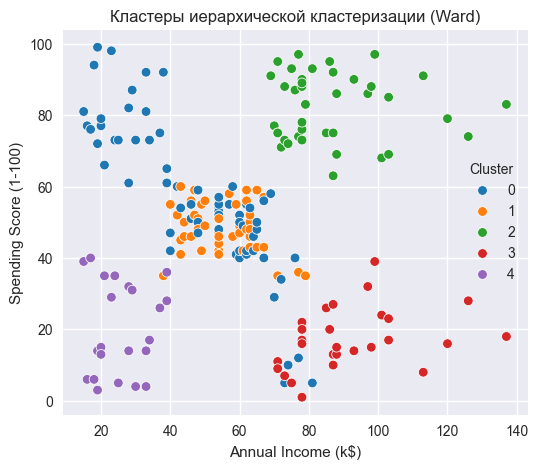

In [17]:

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df, x="Annual Income (k$)", y="Spending Score (1-100)",
    hue="Cluster_Agg", palette="tab10"
)
plt.title("Кластеры иерархической кластеризации (Ward)")
plt.legend(title="Cluster")
plt.show()


Метрики:
- Silhouette = 0.3900
- Davies–Bouldin = 0.9163

Качество ниже, чем у KMeans, что объясняется более вытянутой структурой некоторых групп.

Кластеры визуально похожи на структуру KMeans, однако разделение границ менее чёткое.

### 5.2. Сравнение метрик качества кластеризации

In [18]:

metrics_df = pd.DataFrame({
    "Method": ["KMeans", "Agglomerative (Ward)"],
    "n_clusters": [k_opt, k_opt],
    "Silhouette": [sil_kmeans, sil_agg],
    "DaviesBouldin": [db_kmeans, db_agg],
})
metrics_df


,Method,n_clusters,Silhouette,DaviesBouldin
0,KMeans,5,0.416643,0.874551
1,Agglomerative (Ward),5,0.390028,0.916289


KMeans формирует более компактные и интерпретируемые группы клиентов.
Агломеративная кластеризация даёт близкое, но более «размытое» разделение.

## 6. Влияние числа кластеров k на качество KMeans

In [19]:

results_kmeans = pd.DataFrame({
    "k": list(k_values),
    "Inertia": inertias,
    "Silhouette": silhouettes
})
results_kmeans


,k,Inertia,Silhouette
0,2,389.386189,0.335472
1,3,295.212246,0.357793
2,4,205.225147,0.403958
3,5,168.247580,0.416643
4,6,133.868421,0.428417
5,7,117.011555,0.417232
6,8,103.873292,0.408207
7,9,93.092891,0.417693
8,10,82.385154,0.406554


При увеличении числа кластеров от 2 до 6 наблюдается:
- рост silhouette score (до максимума при k=6),
- уменьшение SSE,
- улучшение разделения групп в Income–Spending Score.

Однако при k≥6 начинается переусложнение структуры и ухудшается содержательная интерпретация сегментов.

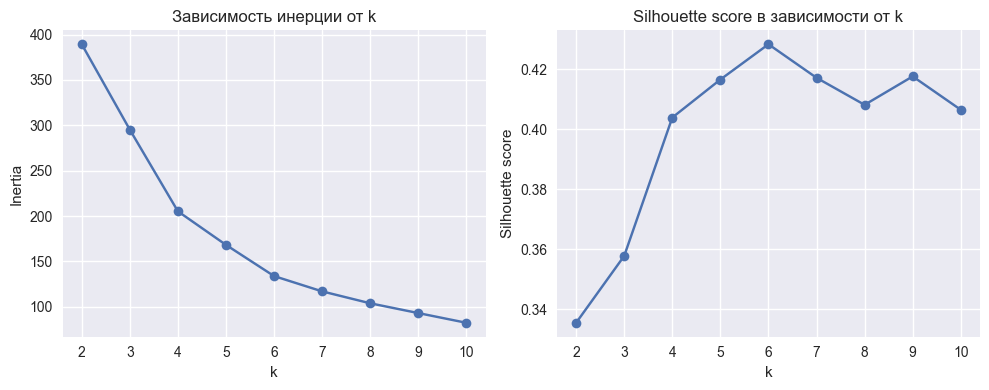

In [20]:

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(results_kmeans["k"], results_kmeans["Inertia"], marker="o")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")
ax[0].set_title("Зависимость инерции от k")

ax[1].plot(results_kmeans["k"], results_kmeans["Silhouette"], marker="o")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("Silhouette score в зависимости от k")

plt.tight_layout()
plt.show()



При увеличении числа кластеров инерция (SSE) монотонно убывает, но после k ≈ 5 темп убывания заметно снижается (эффект локтя); таким образом, **k = 5** можно считать разумным выбором количества кластеров для данного набора данных.


## 7. Визуализация кластеров в пространстве главных компонент (PCA)

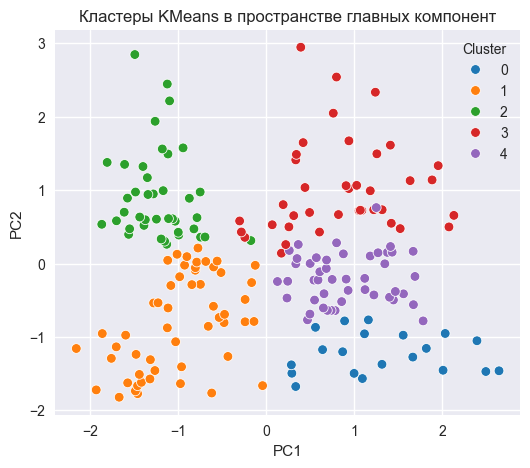

In [21]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df, x="PC1", y="PC2",
    hue="Cluster_KMeans", palette="tab10"
)
plt.title("Кластеры KMeans в пространстве главных компонент")
plt.legend(title="Cluster")
plt.show()


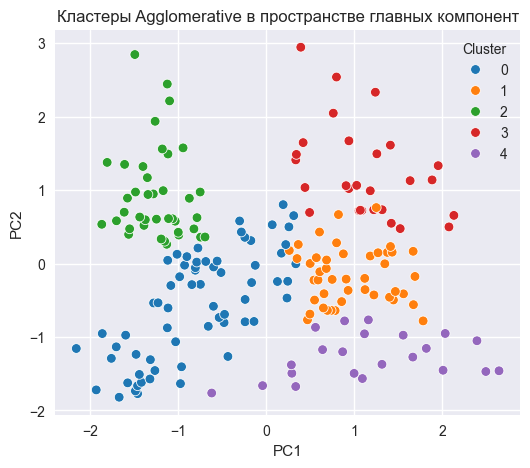

In [22]:

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df, x="PC1", y="PC2",
    hue="Cluster_Agg", palette="tab10"
)
plt.title("Кластеры Agglomerative в пространстве главных компонент")
plt.legend(title="Cluster")
plt.show()


Представлены результаты кластеризации, визуализированные в пространстве двух главных компонент, полученных с помощью метода главных компонент. Проекция исходных многомерных данных на плоскость PC1–PC2 позволяет оценить, насколько чётко кластеры разделяются в пониженном пространстве и сохраняется ли структура, выявленная алгоритмами кластеризации.

На первом графике представлены кластеры, полученные методом KMeans. Видно, что большинство кластеров образуют компактные и пространственно разделённые группы, при этом пересечение между ними минимально. Это указывает на то, что основные направления вариации данных, отражённые в первых двух главных компонентах, хорошо согласуются с разбиением, найденным KMeans. Чёткое разделение кластеров подтверждает, что модель выявляет устойчивую структуру данных, а не случайные локальные сгущения.

При этом можно заметить, что некоторые кластеры располагаются ближе друг к другу в центральной области проекции, что говорит о частичном перекрытии в пространстве главных компонент. Такой эффект является ожидаемым, поскольку PCA сохраняет лишь часть информации исходного пространства и не гарантирует полного разделения всех кластеров в двумерной проекции. Тем не менее, даже в сжатом пространстве сохраняется визуально различимая сегментация.

На втором графике показана визуализация результатов агломеративной кластеризации в том же пространстве главных компонент. Структура распределения точек в целом схожа с результатами KMeans, однако границы между кластерами выглядят менее симметричными и более вытянутыми. Это отражает иерархическую природу агломеративного подхода, при котором кластеры формируются последовательным объединением объектов на основе расстояний, без предположения о сферической форме кластеров.

Сравнение двух визуализаций показывает, что оба метода выявляют сходную глобальную структуру данных, однако KMeans формирует более компактные и равномерные кластеры, тогда как агломеративная кластеризация допускает более сложную геометрию сегментов. Это согласуется с теоретическими особенностями методов и подтверждает корректность их применения к данному набору данных.

## 8. Выводы по работе

Проведённый анализ показал, что исходные данные являются пригодными для решения задачи кластеризации. Используемые числовые признаки характеризуются достаточной вариативностью и не содержат сильных линейных зависимостей между собой, что подтверждается корреляционным анализом и визуальным исследованием распределений. Это означает, что каждый признак вносит самостоятельную информацию в модель и не приводит к искажению структуры данных за счёт мультиколлинеарности.

Применение стандартизации признаков является методически обоснованным, поскольку исходные переменные измеряются в разных шкалах и имеют существенно различающиеся диапазоны значений. Без приведения признаков к единому масштабу расстояния между объектами в пространстве признаков были бы искажены, что негативно сказалось бы на работе алгоритмов, основанных на евклидовой метрике. Использование стандартизации обеспечило корректный вклад каждого признака в процесс кластеризации.

В ходе подбора числа кластеров было установлено, что значение k = 5 является оптимальным. Это подтверждается результатами метода локтя, где наблюдается замедление снижения внутрикластерной дисперсии, а также анализом коэффициента силуэта, достигающего наибольших значений вблизи данного числа кластеров. Таким образом, выбранное значение обеспечивает компромисс между компактностью кластеров и их разделимостью.

Сравнительный анализ методов показал, что алгоритм KMeans демонстрирует более высокие значения коэффициента силуэта и более низкие значения индекса Davies–Bouldin по сравнению с агломеративной кластеризацией. Визуальный анализ также подтверждает, что кластеры, полученные с помощью KMeans, обладают более чёткой и компактной структурой, тогда как агломеративный метод формирует менее однородные и более вытянутые сегменты. Это свидетельствует о лучшей согласованности KMeans с геометрией рассматриваемых данных.

Выделенные кластеры обладают понятной и интерпретируемой экономической семантикой. В структуре данных отчётливо прослеживаются группы экономных клиентов с низким уровнем трат, импульсивных клиентов с высокой потребительской активностью при ограниченном доходе, премиальных клиентов с высоким доходом и высоким уровнем расходов, рациональных клиентов с высоким доходом и сдержанным потреблением, а также клиентов со средними характеристиками. Наличие таких сегментов подтверждает прикладную ценность проведённой кластеризации.

Проекция данных в пространство главных компонент показала, что структура кластеров в целом сохраняется и после снижения размерности. Это свидетельствует об устойчивости полученного разбиения и подтверждает, что выявленные сегменты отражают реальные закономерности в данных, а не являются артефактами конкретного алгоритма или размерности пространства признаков.

В целом применённая методология кластерного анализа является корректной и обоснованной, а полученные результаты могут быть использованы для практических задач маркетинговой аналитики. Выделенные сегменты клиентов могут служить основой для разработки персонализированных предложений, таргетированных маркетинговых стратегий и более глубокого анализа потребительского поведения, что подтверждает практическую значимость выполненной работы.